## Introduction: 

Finding the phase angles $\vec{\phi}$ of a qsvt sequence is a challenging problem that prevents us from performing truely arbitrary polynomial transformations on matricies of interest. Having a more efficient method to compute the phase angles can unlock the ability to perform higher degree polynomial transformations which correspond to better approximations for functions of interest.

There exist both analytic and stochastic methods for computing the phase angles ([1](https://arxiv.org/abs/2002.11649), [2](https://arxiv.org/abs/2003.02831), [3](https://arxiv.org/abs/1806.10236)).

In this project, we explore how we can leverage both state of the art angle solvers and [polynomial decomposition](https://en.wikipedia.org/wiki/Polynomial_decomposition) in a "hybrid workflow" to perform the targeted polynomial transformation.

In [1]:
# Imports: 
import pennylane as qml

import time

import numpy as np
from numpy import random
from numpy.polynomial.polynomial import Polynomial as Poly

import matplotlib.pyplot as plt

from pyqsp.angle_sequence import QuantumSignalProcessingPhases

/Users/jay/.pyenv/versions/3.9/envs/pl_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


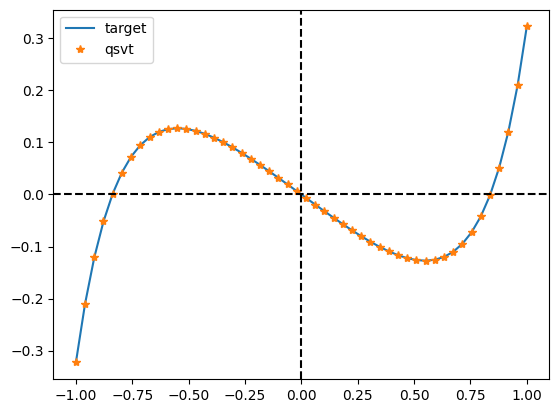

In [2]:
# Simple QSVT workflow:
def get_rand_poly(d):
    """Generate a random polynomial of degree d."""
    coeffs = 2 * random.rand(d+1) - 1
    if d%2 == 0:
        coeffs = np.array([coeffs[i] if i % 2 == 0 else 0 for i in range(d+1)])
    else:
        coeffs = np.array([coeffs[i] if i % 2 != 0 else 0 for i in range(d+1)])
        
    return coeffs / sum(abs(c) for c in coeffs)



my_poly = get_rand_poly(9)
x_vals = np.linspace(-1, 1, 50)

ang_seq = QuantumSignalProcessingPhases(my_poly, signal_operator="Wx")  # use PyQSP to compute phases

qsvt_y_vals = []

for a in x_vals:
    poly_a = qml.matrix(qml.qsvt)(a, ang_seq, wires=[0], convention="Wx")
    qsvt_y_vals.append(poly_a[0,0])


# Plot Poly: 
plt.plot(x_vals, Poly(my_poly)(x_vals), label="target")
plt.plot(x_vals, qsvt_y_vals, "*", label="qsvt")

plt.axvline(0, color="k", linestyle="--")
plt.axhline(0, color="k", linestyle="--")

plt.legend()
plt.show()

### Benchmarking time required for computing phase angles: 

Edit: The code couldn't even converge to solutions for higher degrees with the builtin error tolerance for Polynomials of degree > 15. 

![benchmarks from literature](qsvt_time2.png)

This graph shows that the time to compute a set of phase angles scales quadratically with the degree of the polynomial (with constant error in the convergence).

In [3]:
# num_samples = 5
# degrees = [5, 10, 15, 20]

# times = []
# for degree in degrees:
#     print(f"processing degree {degree}")
#     t_per_sample = []
#     for _ in range(num_samples):
#         my_poly = get_rand_poly(degree)
        
#         t1 = time.time()
#         a_s = QuantumSignalProcessingPhases(my_poly, signal_operator="Wx")
#         t2 = time.time()
        
#         t_per_sample.append(t2-t1)
    
#     times.append(np.mean(t_per_sample))

# plt.xlabel("Poly Degree")
# plt.ylabel("time (sec)")
# plt.bar(degrees, times)
# plt.show()

### Decomposing Polynomials

Consider the polynomial $P(x) = \frac{1}{16} * (x^6 - 3x^4 + 7x^2 - 5)$. We can express this as a composition of simpler polynomials. 

$P(x) = (f \circ g) (x)$

Where, $f(x) = \frac{1}{2} * (x^3 + x)$ and $g(x) = \frac{1}{2} * (x^2 - 1)$ 

Since we can express our polynomial transformation as function composition, we should be able to express the QSVT unitary for $P(x)$ as a composition of the QSVT unitaries for $f(x)$ and $g(x)$. 

$U_{p}(x) = U_{f} * U{g}$

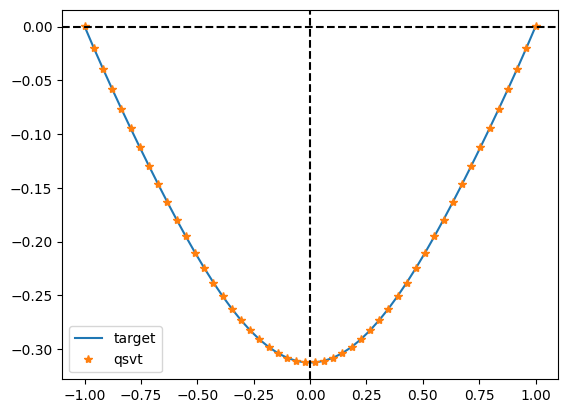

In [4]:
# visualize P(x)
my_poly = [-5/16, 0, 7/16, 0, -3/16, 0, 1/16]           # p(x) = 1/16 * (x^6 - 3x^4 + 7x^2 - 5)
plt.plot(x_vals, Poly(my_poly)(x_vals), label="target")

phase_f = QuantumSignalProcessingPhases([0, 1/2, 0, 1/2], signal_operator="Wx")  # f(x) = 1/2 * x^3 + x
phase_g = QuantumSignalProcessingPhases([-1/2, 0, 1/2], signal_operator="Wx")  # g(x) = 1/2 * (x^2 - 1)

y_vals = []
for a in x_vals:
    u_g = qml.matrix(qml.qsvt)(a, phase_g, wires=[0], convention="Wx")
    u_f = qml.matrix(qml.qsvt)(u_g, phase_f, wires=[0], convention="Wx", direct_be=True)
    
#     poly_p = u_f @ u_g
    y_vals.append(u_f[0,0])


# Plot Poly: 
plt.plot(x_vals, y_vals, "*", label="qsvt")

plt.axvline(0, color="k", linestyle="--")
plt.axhline(0, color="k", linestyle="--")

plt.legend()
plt.show()

### Discussion: 

 ***Note:*** This is only possible under two conditions: 

- The angles computed from the angle solver produce an entirely real polynomial transformation
- The resulting unitary preserves the structure of the block encoding


### What about polynomials that are *irreducible*?

There exist [algorithms](https://www.cs.cornell.edu/~kozen/Papers/poly.pdf) that compute the polynomial decompositions of a given polynomial (just like factorizing a number, the decomposition is not unique). While it is true that a composition of polynomials produces a polynomial, it is not true that every polynomial can be decomposed. 

This may seem like a problem, but actually in these cases we can express our target polynomial as a linear combination of composite polynomials (with some lower degree irreducible polynomials!). Then we can express the unitaries that realize this using the method LCUs!

Consider the example: 

$p(x) = 8(x^9 - 3x^7 + 3x^5 - x^3) + \frac{1}{2} x$

Which can be expressed as: $p(x) = (f \circ g)(x) + h(x)$. Where $f(x) = x^3$, $g(x) = 2(x^3 - x)$ and $h(x) = \frac{1}{2}x$.

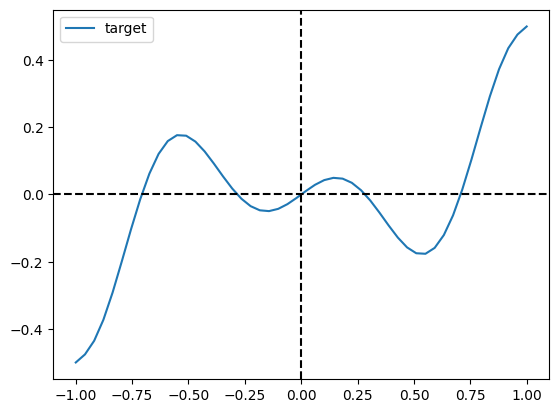

In [5]:
# Visualize Poly:
my_poly = [0, 1/2, 0, -8, 0, 24, 0, -24, 0, 8]
plt.plot(x_vals, Poly(my_poly)(x_vals), label="target")
plt.axvline(0, color="k", linestyle="--")
plt.axhline(0, color="k", linestyle="--")

plt.legend()
plt.show()

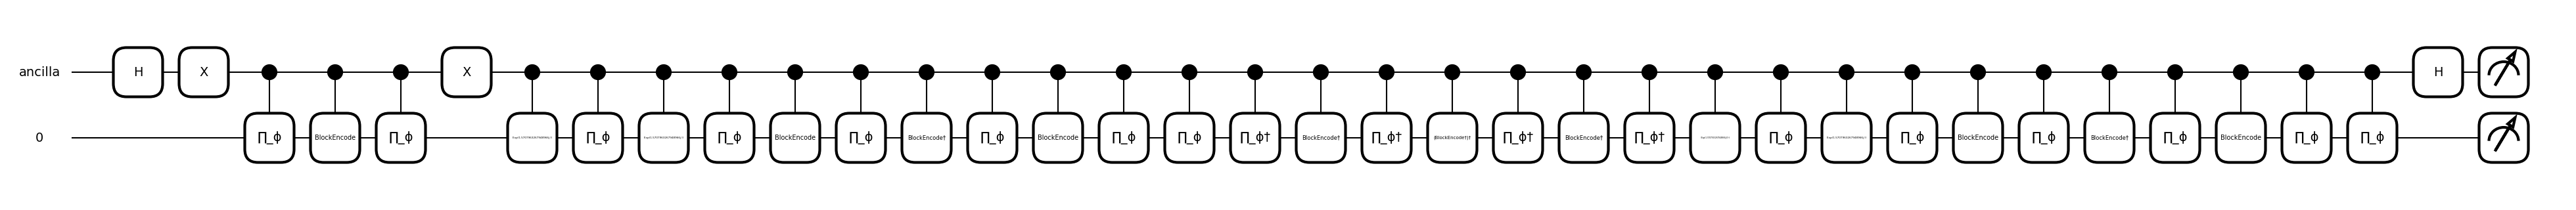

In [7]:
# Construct quantum functions: 

phase_f = QuantumSignalProcessingPhases([0, 0, 0, 1], signal_operator="Wx")  # f(x) = x^3
phase_g = QuantumSignalProcessingPhases([0, -2, 0, 2], signal_operator="Wx")    # g(x) = 2(x^3 - x)
phase_h = QuantumSignalProcessingPhases([0, 1/2], signal_operator="Wx")  # f(x) = 1/2 x


def qsvt_h(a):
    qml.qsvt(a, phase_h, wires=[0])


def qsvt_F_o_G(a):
    qml.custom_qsvt(a, phase_f, wires=[0], custom_phi_vect=phase_g, custom_be=qml.qsvt, convention="Wx")


dev = qml.device("default.qubit", wires=["ancilla", 0], shots=100)
@qml.qnode(dev)
def my_qsvt_circ(a):
    # LCU: 
    qml.Hadamard("ancilla")
    
    qml.ctrl(qsvt_h, control=("ancilla"), control_values=(0))(a)
    qml.ctrl(qsvt_F_o_G, control=("ancilla"), control_values=(1))(a)
    
    qml.Hadamard("ancilla")
    
    return qml.expval(qml.PauliZ("ancilla")), qml.expval(qml.PauliZ(0))

qml.draw_mpl(my_qsvt_circ)(0.5)
plt.show()

### Resource comparison and conclusions

One big take away from this is to understand that what we are trying to perform is not what we expected: 

$U_{p} \neq U_{f} * U_{g}$   but rather:   $U_{p} = U_{f}(U_{g})$

That is, the block encoding is a sub-circuit in the greater qsvt workflow. This means that trying to combine two polynomial transformations actually requires embedding one as a sub-circuit in the larger circuit of the other.

This becomes blatently clear when we start tracking resources. The resource of interest is the number of projector controlled phase shift gates and the total number of qubits. 

Simulating our target polynomial using the **regular framework**:
- requires **10** applications of the **phase gates** (degree + 1 = 9 + 1)
- **0 ancilla** qubits

Simulating our target polynomial using the **hybrid framework**:
- requires **16** applications of the **phase gates** (degree_f + 1 * degree_g + 1 = 3+1 * 3+1).
- **1 ancilla** qubit (for summing the irreducible components) 

We conclude by stating that this workflow "may" improve performance if deep circuits are more efficient to execute then classically computing the phases! 